In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import nipy as ni
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

### Helper functions (dcm)

In [2]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

### Preprocessing (dcm to npy)

In [3]:
# Some constants
TRAINVAL = 'stage1'
INPUT_FOLDER = '../data/DataScienceBowl2017/dcm/{}'.format(TRAINVAL)
OUTPUT_FOLDER = '../data/DataScienceBowl2017/npy/{}'.format(TRAINVAL)
LABEL_FILE = '../data/DataScienceBowl2017/{}_labels.csv'.format(TRAINVAL)
df_labels = pd.read_csv(LABEL_FILE)
patients = df_labels['id'].values
labels = df_labels['cancer'].values

HU converting: (0, 2505) --> (-1024, 3071)
Shape resampling: (189, 512, 512) --> (85, 80, 80)


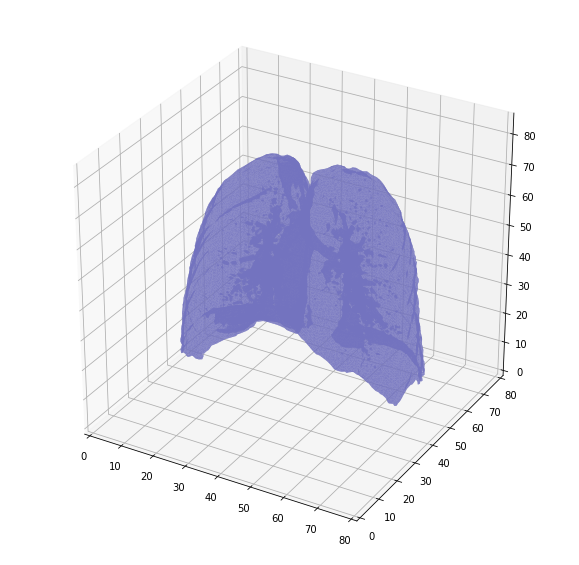

In [22]:
def preprocessing(path):
    patient = load_scan(path)
    patient_pixels = get_pixels_hu(patient)
    pix_resampled, spacing = resample(patient_pixels, patient, [4,4,4])
    plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()
    segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
    segmented_lungs_fill = morphology.binary_dilation(segmented_lungs_fill)
    pix_resampled[segmented_lungs_fill==0] = 0
    print("HU converting: ({}, {}) "
          "--> ({}, {})".format(np.amin(patient[0].pixel_array),
                                np.amax(patient[0].pixel_array),
                                np.amin(patient_pixels),
                                np.amax(patient_pixels)))
    print("Shape resampling: {} --> {}".format(patient_pixels.shape,
                                               pix_resampled.shape))
    return pix_resampled


img_path = os.path.join(INPUT_FOLDER, patients[30])
pix_resampled = preprocessing(img_path)
plot_3d(pix_resampled, -500)


In [ ]:
output_path = os.path.join(OUTPUT_FOLDER, p)
    np.save(output_path, pix_resampled)

from multiprocessing import Pool

def f(p):
    img_path = os.path.join(INPUT_FOLDER, p)
    pix_resampled = preprocessing(img_path)
    output_path = os.path.join(OUTPUT_FOLDER, p)
    np.save(output_path, pix_resampled)
    return pix_resampled.shape

pool = Pool(processes=8)
results = pool.map(f, patients)

### nii to npy

In [7]:
from multiprocessing import Pool, cpu_count
# Some constants 
TRAINVAL = 'stage1'
INPUT_FOLDER = '../data/data-science-bowl/nii/{}'.format(TRAINVAL)
OUTPUT_FOLDER = '../data/data-science-bowl/npy/{}'.format(TRAINVAL)
LABEL_FILE = '../data/data-science-bowl/nii/{}_labels.csv'.format(TRAINVAL)
SPACING_FILE = '../data/data-science-bowl/nii/{}_spacing.csv'.format(TRAINVAL)


def resampling(image, spacing, new_spacing=[4,4,4]):
#     print image.shape
    if spacing[0] == 0:
        print "replace 0 slice thick with 1"
        spacing = (1., spacing[1], spacing[2])
    spacing = np.array([spacing[1], spacing[2], spacing[0]],
                       dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image,
                                             real_resize_factor,
                                             mode='nearest')
    return image, new_spacing

def preprocessing(img_path, img_spacing):
    # load
    img = ni.load_image(img_path)
        
    # resampling
    patient_pixels = img.get_data().astype('int16')

#     patient_pixels[patient_pixels==-3024]=0
#     patient_pixels[patient_pixels==-2048]=0
    patient_pixels[patient_pixels==-2000]=0
    pix_resampled, new_spacing = resampling(patient_pixels, img_spacing)
    
    print("Spacing change: {} --> {}".format(img_spacing, new_spacing)) 
    print pix_resampled.shape
    print("Data range: ({}, {}) --> ({}, {})".format(
        np.min(patient_pixels),
        np.max(patient_pixels),
        np.min(pix_resampled),
        np.max(pix_resampled)))
    print("Shape resampling: {} --> {}".format(img.shape,
                                               pix_resampled.shape))
    return pix_resampled


df_labels = pd.read_csv(LABEL_FILE)
df_spacing = pd.read_csv(SPACING_FILE)
patients = df_spacing['id'].values
spacing = df_spacing['spacing'].values
from ast import literal_eval
spacing = [literal_eval(s) for s in spacing]


# # single process
for p, s in zip(patients, spacing):
    img_path = os.path.join(INPUT_FOLDER,
                        'Axial_{}.nii.gz'.format(p))
    output_path = os.path.join(OUTPUT_FOLDER, p)
    if not os.path.exists(output_path+'.npy'):
        if s[0] != 0:
            pix_resampled = preprocessing(img_path, s)
            np.save(output_path, pix_resampled)
        else:
            print "got zero slice thick"

# # multiprocessing
# def f(x):
#     p = x[0]
#     s = x[1]
#     img_path = os.path.join(INPUT_FOLDER,
#                         'Axial_{}.nii.gz'.format(p))
#     output_path = os.path.join(OUTPUT_FOLDER, p)
#     pix_resampled = preprocessing(img_path, s)
#     np.save(output_path, pix_resampled)
    

# pool = Pool(cpu_count())
# pool.map(f, zip(patients, spacing))
# pool.close()
# pool.join()


got zero slice thick
Spacing change: (1.8, 0.625, 0.625) --> [ 4.          4.          3.98734167]
(80, 80, 79)
Data range: (-1024, 3071) --> (-1165, 2361)
Shape resampling: (512, 512, 175) --> (80, 80, 79)
Spacing change: (2.5, 0.56640601, 0.56640601) --> [ 4.02777608  4.02777608  4.        ]
(72, 72, 75)
Data range: (-1024, 1958) --> (-1256, 1609)
Shape resampling: (512, 512, 120) --> (72, 72, 75)
Spacing change: (2.0, 0.72265625, 0.72265625) --> [ 4.02173913  4.02173913  4.        ]
(92, 92, 84)
Data range: (-1024, 1849) --> (-1132, 1765)
Shape resampling: (512, 512, 168) --> (92, 92, 84)
Spacing change: (2.0, 0.703125, 0.703125) --> [ 4.  4.  4.]
(90, 90, 82)
Data range: (-1024, 1942) --> (-1212, 1619)
Shape resampling: (512, 512, 164) --> (90, 90, 82)
Spacing change: (2.5, 0.703125, 0.703125) --> [ 4.          4.          3.99350649]
(90, 90, 77)
Data range: (-1024, 3071) --> (-1149, 3630)
Shape resampling: (512, 512, 123) --> (90, 90, 77)
Spacing change: (1.25, 0.74218798, 0.7421

### Visualization

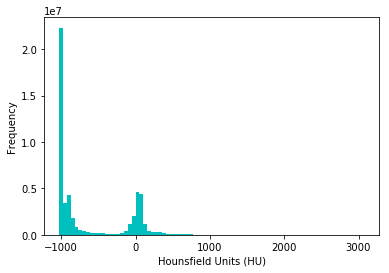

In [8]:
patient_scan = load_scan(os.path.join(INPUT_FOLDER, patients[0]))
patient_pixels = get_pixels_hu(patient_scan)
plt.hist(patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

[-1203 -1201 -1196 ...,  1973  2166  2256]
[-1203 -1201 -1196 ...,  1973  2166  2256]


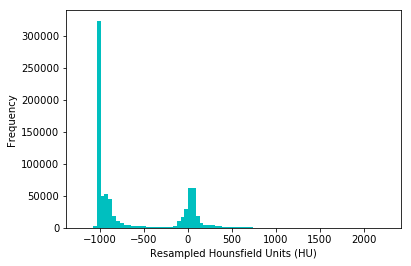

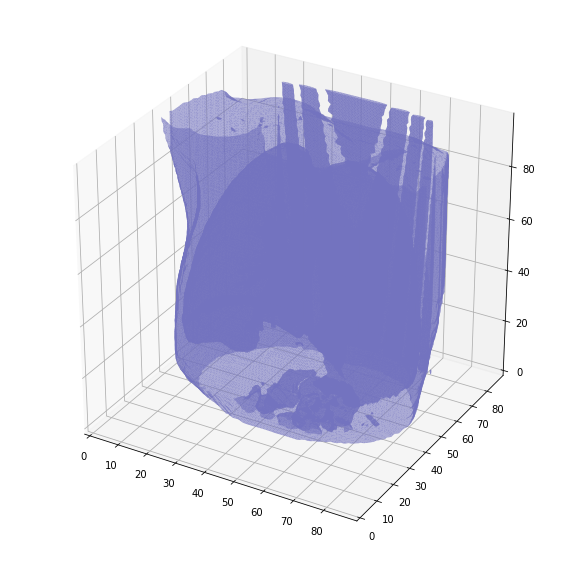

In [28]:
pix_resampled, spacing = resample(patient_pixels, patient, [4,4,4])
print(np.unique(pix_resampled))
print(np.unique(pix_resampled))
plt.hist(pix_resampled.flatten(), bins=80, color='c')
plt.xlabel("Resampled Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
plot_3d(pix_resampled, -320)

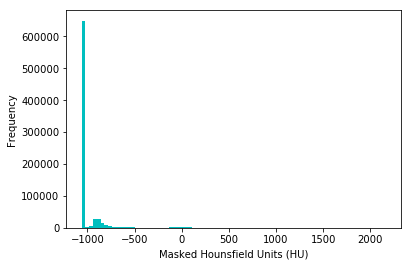

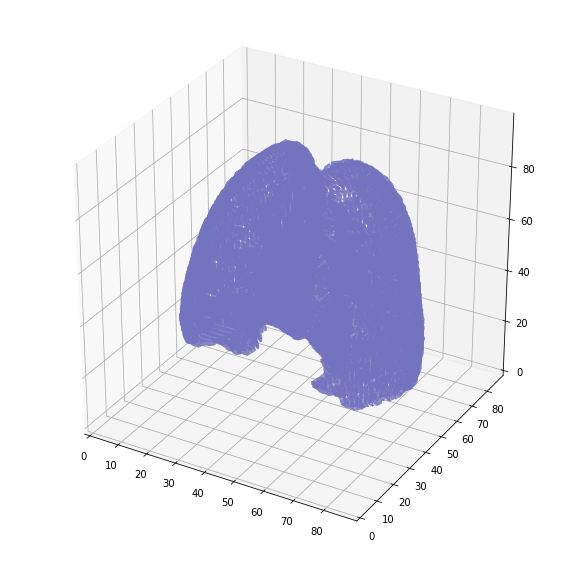

In [31]:
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
segmented_lungs_fill = morphology.binary_dilation(segmented_lungs_fill)
pix_segmented = pix_resampled.copy()
pix_segmented[segmented_lungs_fill==0] = -1024
plt.hist(pix_segmented.flatten(), bins=80, color='c')
plt.xlabel("Masked Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
plot_3d(pix_segmented, -500)

### Save image spacing

In [24]:
# Some constants
TRAINVAL = 'stage1'
INPUT_FOLDER = '../data/DataScienceBowl2017/dcm/{}'.format(TRAINVAL)
OUTPUT_FOLDER = '../data/DataScienceBowl2017/npy/{}'.format(TRAINVAL)
LABEL_FILE = '../data/DataScienceBowl2017/{}_labels.csv'.format(TRAINVAL)
patients = os.listdir(INPUT_FOLDER)
# spacing
df_spacing = pd.DataFrame([],columns=['id', 'spacing'])
for i, p in enumerate(patients):
    path = os.path.join(INPUT_FOLDER, p)
    patient = load_scan(path)
    spacing = tuple(np.array([patient[0].SliceThickness] + patient[0].PixelSpacing, dtype=np.float32))
    df_spacing.loc[i] = [p, spacing]
    print spacing
df_spacing.to_csv('../data/data-science-bowl/stage1_spacing.csv', index=False)

(2.0, 0.69335902, 0.69335902)
(1.25, 0.58203101, 0.58203101)
(1.5, 0.80859375, 0.80859375)
(2.0, 0.66500002, 0.66500002)
(2.0, 0.72265601, 0.72265601)
(2.0, 0.6640625, 0.6640625)
(2.5, 0.68359399, 0.68359399)
(2.5, 0.59765601, 0.59765601)
(2.5, 0.67382801, 0.67382801)
(1.8, 0.6640625, 0.6640625)
(1.30005, 0.53710938, 0.53710938)
(1.25, 0.66210902, 0.66210902)
(2.0, 0.6640625, 0.6640625)
(2.0, 0.92578125, 0.92578125)
(2.0, 0.63999999, 0.63999999)
(2.0, 0.78125, 0.78125)
(2.0, 0.66406202, 0.66406202)
(2.5, 0.58593798, 0.58593798)
(1.701, 0.68300003, 0.68300003)
(1.8, 0.6640625, 0.6640625)
(2.5, 0.78125, 0.78125)
(2.5, 0.64453101, 0.64453101)
(2.0, 0.7421875, 0.7421875)
(2.0, 0.703125, 0.703125)
(2.5, 0.61328101, 0.61328101)
(2.0, 0.68199998, 0.68199998)
(2.0, 0.7109375, 0.7109375)
(2.0, 0.6640625, 0.6640625)
(2.0, 0.66406202, 0.66406202)
(2.0, 0.71484375, 0.71484375)
(2.5, 0.625, 0.625)
(1.8, 0.625, 0.625)
(1.8, 0.7421875, 0.7421875)
(2.5, 0.74218798, 0.74218798)
(1.5, 0.6015625, 0.60156